# Q1

In [1]:
import numpy as np
import scipy.optimize

mu = np.array([0.02, 0.07, 0.15, 0.20]) 
sigma = np.array([0.05, 0.12, 0.17, 0.25])
R = np.array([ 
    [1, 0.3, 0.3, 0.3],
    [0.3, 1, 0.6, 0.6],
    [0.3, 0.6, 1, 0.6],
    [0.3, 0.6, 0.6, 1]
])
ones = np.ones(4)  
target_return = 0.045  

Sigma = np.diag(sigma) @ R @ np.diag(sigma)

def solve_weights(mu, Sigma, target_return):
    def objective(weights):
        return weights.T @ Sigma @ weights

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  
        {'type': 'eq', 'fun': lambda w: w @ mu - target_return} 
    ]
    
    w0 = np.array([0.25, 0.25, 0.25, 0.25])
    
    result = scipy.optimize.minimize(objective, w0, method='SLSQP', constraints=constraints)
    return result.x

optimal_weights = solve_weights(mu, Sigma, target_return)

portfolio_risk = np.sqrt(optimal_weights.T @ Sigma @ optimal_weights)

optimal_weights, portfolio_risk

(array([0.78511204, 0.05386241, 0.13355439, 0.02747116]), 0.05840090673911342)

# Q2

In [2]:
import numpy as np
from scipy.stats import norm

mu = np.array([0, 0, 0])
sigma = np.array([0.30, 0.20, 0.15])
weights = np.array([0.5, 0.2, 0.3])

corr_matrix = np.array([
    [1, 0.8, 0.5],
    [0.8, 1, 0.3],
    [0.5, 0.3, 1]
])

cov_matrix = np.diag(sigma) @ corr_matrix @ np.diag(sigma)

confidence_level = 0.99

Factor = norm.ppf(1 - confidence_level)

portfolio_variance = weights.T @ cov_matrix @ weights

Sigma_w = cov_matrix @ weights

VaR_sensitivities = mu + Factor * (Sigma_w / np.sqrt(portfolio_variance))
ES_sensitivities = mu - (norm.pdf(Factor) / (1 - confidence_level)) * (Sigma_w / np.sqrt(portfolio_variance))


import pandas as pd

data = {
    'Asset': [1, 2, 3],
    'Partial VaR': [-0.683865, -0.386799, -0.220709],
    'Partial ES': [-0.783480, -0.443142, -0.252859]
}

summary_df = pd.DataFrame(data)

print(summary_df)

   Asset  Partial VaR  Partial ES
0      1    -0.683865   -0.783480
1      2    -0.386799   -0.443142
2      3    -0.220709   -0.252859


# Q3

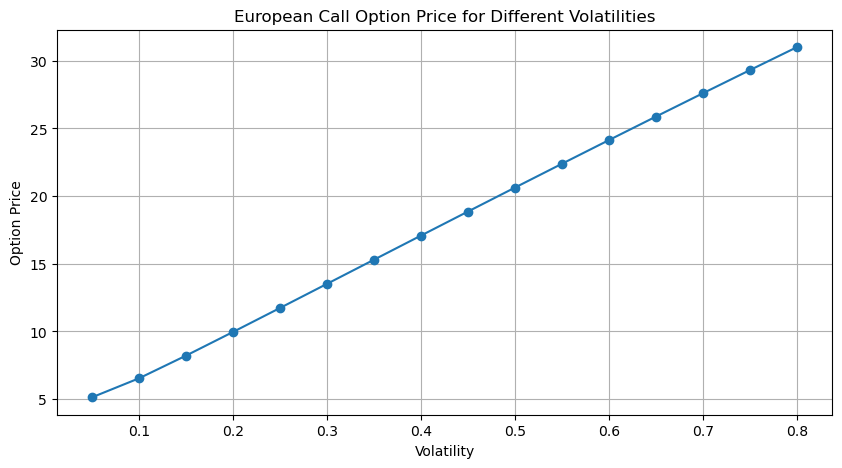

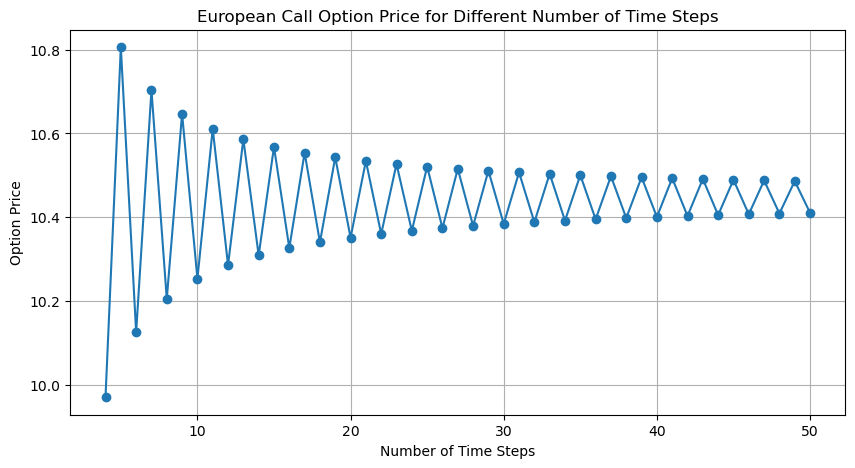

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

S = 100  
E = 100  
T = 1   
r = 0.05 
N = 50   

def european_call_binomial(S, E, T, r, sigma, N):
    delta_T = T/N
    u = np.exp(sigma * np.sqrt(delta_T))
    d = 1/u
    p = (np.exp(r * delta_T) - d) / (u - d)
    
    stock_price = np.zeros(N+1)
    option_value = np.zeros(N+1)

    for i in range(N+1):
        stock_price[i] = S * (u ** (N-i)) * (d ** i)
        option_value[i] = max(stock_price[i] - E, 0)

    for j in range(N-1, -1, -1):
        for i in range(j+1):
            option_value[i] = (p * option_value[i] + (1-p) * option_value[i+1]) * np.exp(-r * delta_T)
    return option_value[0]

# Plot 1: Option value for a range of volatilities
volatilities = np.linspace(0.05, 0.8, 16)
prices = [european_call_binomial(S, E, T, r, sigma, 4) for sigma in volatilities]

plt.figure(figsize=(10, 5))
plt.plot(volatilities, prices, 'o-')
plt.title('European Call Option Price for Different Volatilities')
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()

# Plot 2: Option value for increasing number of time steps
fixed_volatility = 0.2
time_steps = range(4, 51)
prices_time = [european_call_binomial(S, E, T, r, fixed_volatility, N) for N in time_steps]

plt.figure(figsize=(10, 5))
plt.plot(list(time_steps), prices_time, 'o-')
plt.title('European Call Option Price for Different Number of Time Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()

# Q4.2

In [4]:
import numpy as np
from scipy.stats import norm
import pandas as pd

percentiles = [99.95, 99.75, 99.5, 99.25, 99, 98.5, 98, 97.5]

ES_values = []
for percentile in percentiles:
    c = percentile / 100  
    z = norm.ppf(c)  
    pdf_value = norm.pdf(z) 
    ES = -pdf_value / (1 - c)  
    ES_values.append(ES)

ES_table = pd.DataFrame({
    'Percentile': percentiles,
    'Standardized ES': ES_values
})

ES_table

,Percentile,Standardized ES
0,99.95,-3.554381
1,99.75,-3.104357
2,99.50,-2.891949
3,99.25,-2.761240
4,99.00,-2.665214
5,98.50,-2.524695
6,98.00,-2.420907
7,97.50,-2.337803


# Q5

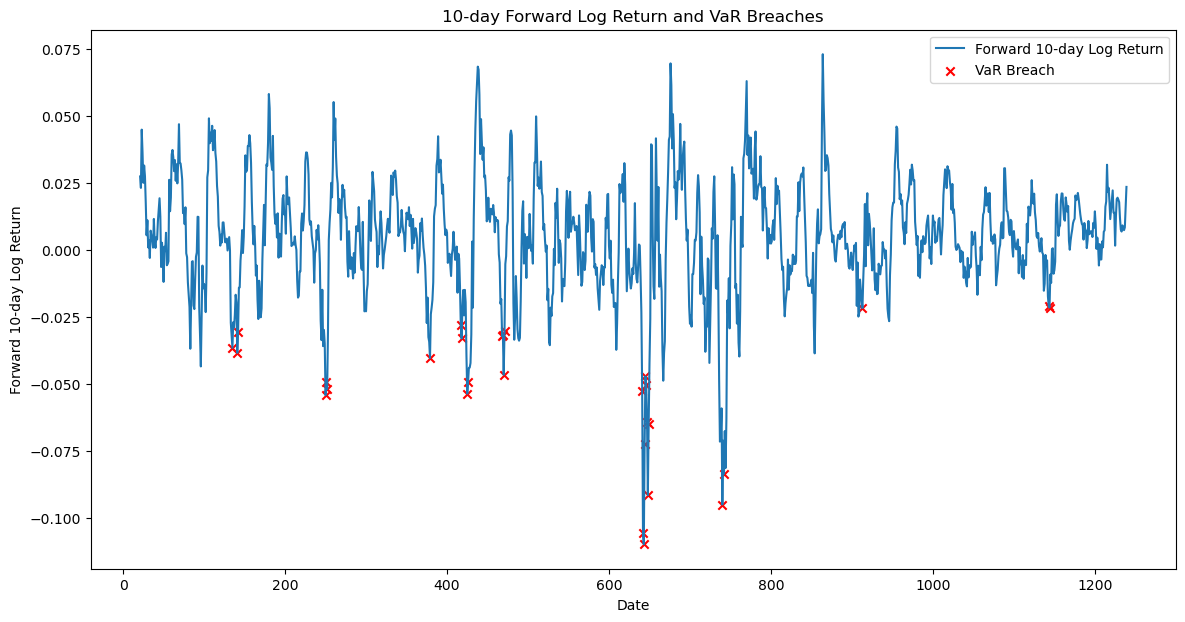

Count of VaR breaches: 29
Percentage of VaR breaches: 2.32%
Count of consecutive VaR breaches: 17
Percentage of consecutive VaR breaches: 1.36%


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load the S&P 500 index data
sp500_data = pd.read_csv('/Users/archer/Desktop/Jan 24 Exam 1 Data.csv')

# Calculate daily log returns
sp500_data['log_return'] = np.log(sp500_data['SP500'] / sp500_data['SP500'].shift())

# Calculate the rolling standard deviation (volatility) of daily returns with a 21-day window
sp500_data['rolling_vol'] = sp500_data['log_return'].rolling(window=21).std(ddof=0)

# Scaling the daily volatility to 10-day volatility
sp500_data['vol_10d'] = sp500_data['rolling_vol'] * np.sqrt(10)

# The 99% VaR is calculated using the z-score corresponding to the 99th percentile
z_score = norm.ppf(0.99)
sp500_data['VaR_99_10d'] = z_score * sp500_data['vol_10d']

# Calculate the actual 10-day forward log return
sp500_data['forward_log_return_10d'] = sp500_data['log_return'].rolling(window=10).sum().shift(-10)

# A VaR breach occurs when the forward return is less than the negative of the VaR
sp500_data['VaR_breach'] = sp500_data['forward_log_return_10d'] < -sp500_data['VaR_99_10d']

# Count the number of VaR breaches and calculate the percentage
num_breaches = sp500_data['VaR_breach'].sum()
percent_breaches = (num_breaches / len(sp500_data)) * 100

# Identify consecutive breaches
sp500_data['consec_breach'] = sp500_data['VaR_breach'] & sp500_data['VaR_breach'].shift(1)
consecutive_breaches = sp500_data['consec_breach'].sum()
consecutive_breach_percent = (consecutive_breaches / len(sp500_data)) * 100

# Drop rows with NaN values resulting from rolling calculations
sp500_data.dropna(inplace=True)

# Plot the forward returns and breaches
plt.figure(figsize=(14, 7))
plt.plot(sp500_data.index, sp500_data['forward_log_return_10d'], label='Forward 10-day Log Return')
breaches = sp500_data[sp500_data['VaR_breach']]
plt.scatter(breaches.index, breaches['forward_log_return_10d'], color='red', label='VaR Breach', marker='x')
plt.title('10-day Forward Log Return and VaR Breaches')
plt.xlabel('Date')
plt.ylabel('Forward 10-day Log Return')
plt.legend()
plt.show()

# Print the results
print(f'Count of VaR breaches: {num_breaches}')
print(f'Percentage of VaR breaches: {percent_breaches:.2f}%')
print(f'Count of consecutive VaR breaches: {consecutive_breaches}')
print(f'Percentage of consecutive VaR breaches: {consecutive_breach_percent:.2f}%')
